# Introduction

RNNs is a popular approach for machine translation, and is adopted by various applications including Google Translate. This project seeks to perform a basic machine translation task using an encoder-decoder-based seq2seq model combined with an attention mechanism. The encoder is a Bidirectional LSTM and the decoder is a simple LSTM. The attention is an additive attention mechanism, which uses attention weights ($\alpha$) and parameterizes the context vector using feed-forward network layers. This mechanism is proposed by Bahdanau et al., in their paper [*Neural Machine Translation By Jointly Learning to Align and Translate*](https://arxiv.org/pdf/1409.0473.pdf) published in 2015.

The model is trained on multiple data sources. The word feature vector data is retrieved from [*nlp.standford.edu.*](https://nlp.stanford.edu/data/glove.6B.zip) and is approximately 350MB in size. The data of English-Italian tab-delimited sentence pairs, which is originally collected for the Tatoeba Project, is retrieved from [manythings.org](http://www.manythings.org/anki/), and is approximately 50MB in size. The training time is within 2 hours (for 35 epochs).

The model achieves an accuracy of 0.85 on validation data, although the translated sentences differ from the groundtruths to a considerable extent.

# Data Preprocessing

Import basic libraries.

In [1]:
import os, sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Set basic parameters.

In [2]:
BATCHSIZE = 128
EPOCH = 35
LATENT_DIM = 500
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 23000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

Store data from textfile to usable arrays.

In [3]:
eng = []
man = []
man_inputs = []
count = 0

# preprocess the translation file
for line in open('Italian.txt'):
    if '\t' not in line:
        continue
    
    count += 1
    if (count > SAMPLES):
        break
    
    # split original and translation into lists
    e, m, _ = line.rstrip().split('\t')
    eng.append(e)
    man.append(m + ' <eos>')
    man_inputs.append('<sos> ' + m)
    
    if (count % 2000 == 0):
        print ('Sample Count: {}.'.format(count))

Sample Count: 2000.
Sample Count: 4000.
Sample Count: 6000.
Sample Count: 8000.
Sample Count: 10000.
Sample Count: 12000.
Sample Count: 14000.
Sample Count: 16000.
Sample Count: 18000.
Sample Count: 20000.
Sample Count: 22000.


Tokenize the input and output sentences, and create maps that can be used by the network.

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# tokenize input and generate idx map
tok_in = Tokenizer(num_words=MAX_WORD_NUM)
tok_in.fit_on_texts(eng)
eng_seq = tok_in.texts_to_sequences(eng)
word2idx_in = tok_in.word_index
max_in_len = max(len(s) for s in eng_seq)

print("Number of input tokens: {}".format(len(word2idx_in)))
print("Maximum input sequence length: {}".format(max_in_len))

# tokenize output and generate idx map
tok_out = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tok_out.fit_on_texts(man + man_inputs)
man_seq = tok_out.texts_to_sequences(man)
man_seq_inputs = tok_out.texts_to_sequences(man_inputs)
word2idx_out = tok_out.word_index
max_out_len = max(len(s) for s in man_seq)
out_word_num = len(word2idx_out) + 1

print("Number of output tokens: {}".format(len(word2idx_out)))
print("Maximum output sequence length: {}".format(max_out_len))

Using TensorFlow backend.


Number of input tokens: 2565
Maximum input sequence length: 5
Number of output tokens: 8143
Maximum output sequence length: 9


Pad the input and output sequences to be the same length.

In [5]:
from keras.preprocessing.sequence import pad_sequences

eng_seq_padded = pad_sequences(eng_seq, maxlen=max_in_len)
man_seq_padded = pad_sequences(man_seq, maxlen=max_out_len, padding='post')
man_seq_inputs_padded = pad_sequences(man_seq_inputs, maxlen=max_out_len, padding='post')

Load in word vectors and use them to create word embeddings. [The dataset](https://nlp.stanford.edu/data/glove.6B.zip) of the word vectors is downloaded from *nlp.stanford.edu*.

In [6]:
wordVec = {}

print('Loading wordVec')

# load in word vectors in a dict
with open('glove.6B.100d.txt') as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec

print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [7]:
wordNum = min(MAX_WORD_NUM, len(word2idx_in) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

# create word embedding by fetching each word vector
for tok, idx in word2idx_in.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

Create translated target matrix by loading the padded output target sequence using one-hot encoding.

In [8]:
man_target_one_hot = np.zeros((len(eng), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(man_seq_padded):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

# Model Definition

Create the encoder and decoder before attention.

In [9]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
import keras.backend as K
from keras.models import Model

# Embedding
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

# Encoder
input_layer_encoder = Input(shape=(max_in_len,))
embed_encoder = embedding(input_layer_encoder)
encoder = Bidirectional(LSTM(LATENT_DIM, return_sequences=True, dropout=0.2))
encoder_out = encoder(embed_encoder)

# Decoder input
input_layer_decoder = Input(shape=(max_out_len,))
embed_decoder = Embedding(out_word_num, EMBEDDING)
decoder_input = embed_decoder(input_layer_decoder)

# Decoder output, after attention
decoder = LSTM(LATENT_DIM_DECODER, return_state=True)
dense_decode = Dense(out_word_num, activation='softmax')
s0 = Input(shape=(LATENT_DIM_DECODER,))
c0 = Input(shape=(LATENT_DIM_DECODER,))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Implementation of Attention. 

In each attention iteration, the hidden states, encoded by the encoder, is concatenated with the predicted output of the previous word. During training and using teacher forcing, this predicted output is replaced by the groundtruth translation. The concatenated result is subsequently passed through dense layers (a feedfoward NN) to form the alpha attention weights. The weights are then used to compute the context vector by performing dot product: $context=\sum_{t'=1}^{|T_{x}|} \alpha(t')h(t')$. Eventually, the context vector is passed through a "softmax over time" layer to become the input to the decoder LSTM. The "softmax over time" activation function is implemented as follows: 
$\alpha(t') = \dfrac {exp(s(t'))}{\sum_{x=1}^{|T_{x}|} exp(s(x)) }$. 

<img src="attention.png">

In [10]:
# Dimension of x is N x T x D.
def softmax(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

# Some of the common layers for attention
repeat_attn = RepeatVector(max_in_len)
concat_attn = Concatenate(axis=-1)
dense1_attn = Dense(10, activation='tanh')  # over time dimension T
dense2_attn = Dense(1, activation=softmax)
dot_attn = Dot(axes=1)                      # over time dimension T

def iterAttn(h, prevOut):
    """
    h: encoder encoded hidden states at all time.
    prevOut: output at the previous time (word).
    An iteration of attention.
    """
    prevOutRepeat = repeat_attn(prevOut) # Tx, LATENT_DIM_DECODE
    total = concat_attn([h, prevOutRepeat]) # Tx, LATENT_DIM_DECODE + LATENT_DIM * 2
    d = dense1_attn(total)
    alphaLayer = dense2_attn(d)
    context = dot_attn([alphaLayer, h])
    
    return context

Execute encoder-decoder and attention (with teacher forcing) inference for $Ty$ times, to get a list of outputs.

In [11]:
s = s0
c = c0

# Iterate attention Ty times
all_out = []
for t in range(max_out_len):
    # Get context vector with encoder and attention
    context = iterAttn(encoder_out, s) 
    
    # For teacher forcing, get the previous word
    select_layer = Lambda(lambda x: x[:, t:t+1])
    prevWord = select_layer(decoder_input)
    
    # Concat context and previous word as decoder input
    concat2 = Concatenate(axis=2)
    decoder_in_concat = concat2([context, prevWord])
    
    # pass into decoder, inference output
    pred, s, c = decoder(decoder_in_concat, initial_state=[s, c])
    pred = dense_decode(pred)
    all_out.append(pred)

The output needs to be stacked to be considered as the network's output. Also, need batchsize N to be the first dimension, and thus a permutation of dimensions is required. Afterwards, the model can be defined.

In [12]:
def stack(outputs):
    outputs = K.stack(outputs)
    return K.permute_dimensions(outputs, pattern=(1, 0, 2))

stack_layer = Lambda(stack)
all_out = stack_layer(all_out)

In [13]:
attnModel = Model(inputs=[input_layer_encoder, input_layer_decoder, s0, c0,],
                 outputs=all_out)

# Model Training

First, define customized loss and accuracy metrics for training.

In [14]:
def myLoss(y_train, pred):
    mask = K.cast(y_train > 0, dtype='float32')
    val = mask * y_train * K.log(pred)
    return -K.sum(val) / K.sum(mask)

def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32') # filter out padding value 0.
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

Train model using Adam optimizer and defined loss and metrics. 

In [15]:
attnModel.compile(optimizer='adam', loss=myLoss, metrics=[acc])

# Define empty s0 and c0
init_s = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))
init_c = np.zeros((len(eng_seq_padded), LATENT_DIM_DECODER))

# Train
history = attnModel.fit(
    x=[eng_seq_padded, man_seq_padded, init_s, init_c],
    y=man_target_one_hot,
    batch_size=BATCHSIZE,
    epochs=EPOCH,
    validation_split=0.22
)


Train on 17940 samples, validate on 5060 samples
Epoch 1/35
17940/17940 [==============================] - 108s 6ms/step - loss: 5.6283 - acc: 0.2838 - val_loss: 5.1923 - val_acc: 0.2935
Epoch 2/35
17940/17940 [==============================] - 102s 6ms/step - loss: 4.2970 - acc: 0.3621 - val_loss: 4.1420 - val_acc: 0.4334
Epoch 3/35
17940/17940 [==============================] - 101s 6ms/step - loss: 3.3200 - acc: 0.5013 - val_loss: 3.4459 - val_acc: 0.5511
Epoch 4/35
17940/17940 [==============================] - 100s 6ms/step - loss: 2.6225 - acc: 0.6064 - val_loss: 3.0492 - val_acc: 0.6307
Epoch 5/35
17940/17940 [==============================] - 100s 6ms/step - loss: 2.0952 - acc: 0.6729 - val_loss: 2.8054 - val_acc: 0.6775
Epoch 6/35
17940/17940 [==============================] - 99s 6ms/step - loss: 1.6551 - acc: 0.7339 - val_loss: 2.6354 - val_acc: 0.7186
Epoch 7/35
17940/17940 [==============================] - 104s 6ms/step - loss: 1.2842 - acc: 0.7898 - val_loss: 2.5062 - v

Plot training history.

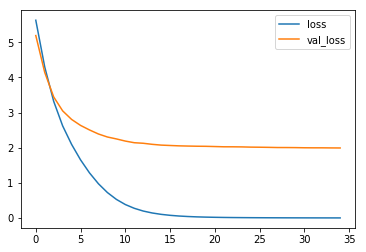

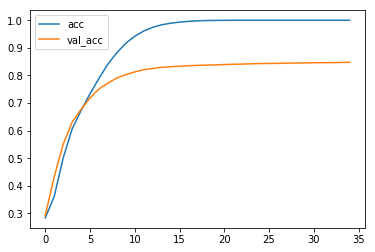

In [16]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [17]:
attnModel.save('attention_model_35_man.h5')

# Inference Model

Since in the inference model teacher forcing is not available, thus the model needs to be modified to use the previous inference result.

In [18]:
# Encoder
encoder_inf = Model(input_layer_encoder, encoder_out)
encoder_out_inf = Input(shape=(max_in_len, LATENT_DIM * 2,))

# Decoder
decoder_in_inf = Input(shape=(1,))
decoder_in_embed_inf = embed_decoder(decoder_in_inf)

# Context, concat without teacher forcing.
context_inf = iterAttn(encoder_out_inf, s0)
decoder_in_concat_inf = concat2([context_inf, decoder_in_embed_inf])

# Decoder inference
pred, s, c = decoder(decoder_in_concat_inf, initial_state=[s0, c0])
pred_out = dense_decode(pred)

# Define model
decoder_inf = Model(
    inputs=[decoder_in_inf, encoder_out_inf, s0, c0],
    outputs=[pred_out, s, c]
)

Reverse the word-to-index maps to convert translated indices to words. Then use the inference encoder and decoder models to create predictions.

In [19]:
idx2word_in = {b:a for a, b in word2idx_in.items()}
idx2word_out = {b:a for a, b in word2idx_out.items()}

def inference(eng_seq):
    # Encode
    encoder_output = encoder_inf.predict(eng_seq)
    
    # Create output seq matrix
    target_output = np.zeros((1, 1))
    target_output[0, 0] = word2idx_out['<sos>']
    
    # init
    eos = word2idx_out['<eos>']
    s0 = np.zeros((1, LATENT_DIM_DECODER))
    c0 = np.zeros((1, LATENT_DIM_DECODER))
    
    output_seq = []
    s = s0
    c = c0
    for _ in range(max_out_len):
        # Decoder inference
        pred, s, c = decoder_inf.predict([target_output, encoder_output, s, c])
        
        # update output seq
        tok = np.argmax(pred.flatten())
        if tok == eos:
            break
        if tok > 0:
            word = idx2word_out[tok]
            output_seq.append(word)

        # Update decoder input
        target_output[0, 0] = tok
        
    sentence = ' '.join(output_seq)
    return sentence

Observe some of the sample inference results:

In [20]:
for _ in range(20):
    i = np.random.choice(len(eng))
    eng_sen = eng_seq_padded[i:i+1]
    man_pred = inference(eng_sen)

    print('--------------------------------------')
    print('English: {}'.format(eng[i]))
    print('Prediction: {}'.format(man_pred))
    print('Ground truth: {}'.format(man[i])) 

--------------------------------------
English: I'll be good.
Prediction: starò buona buona buona buona buona buona buona buona
Ground truth: Io sarò buona. <eos>
--------------------------------------
English: Shut it down.
Prediction: abbassatelo. così! morale! morale! morale! morale! morale! morale! morale!
Ground truth: Lo spenga. <eos>
--------------------------------------
English: I helped Tom.
Prediction: aiutai boston. boston. boston. boston. boston. boston. boston. boston.
Ground truth: Io ho aiutato Tom. <eos>
--------------------------------------
English: We can't go.
Prediction: dovremmo andare? te. te. te. te. te. te. te.
Ground truth: Noi non riusciamo ad andare. <eos>
--------------------------------------
English: You did that.
Prediction: potresti cosa? cosa? cosa? cosa? cosa? cosa? cosa? cosa?
Ground truth: Tu hai fatto quello. <eos>
--------------------------------------
English: I'm happy now.
Prediction: buon adesso. adesso. adesso. adesso. adesso. adesso. adesso

# Conclusion

This project implements an encoder-decoder-based seq2seq model using BiLSTM and attention mechanism. It is observed that the model achieves an accuracy of 0.85 on validation data, although the translated sentences differ from the groundtruth to a considerable extent.
